In [12]:
#Credit to https://github.com/BYUCamachoLab/ottoeplitz
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import ottoeplitz
from scipy.stats import chi2, binom
import os


""" 
Toeplitz Hashing Example
======================

In this example, we generate a large Gaussian input data set. We plot the data before
and after hashing. The data after hashing should be uniform.

"""



' \nToeplitz Hashing Example\n======================\n\nIn this example, we generate a large Gaussian input data set. We plot the data before\nand after hashing. The data after hashing should be uniform.\n\n'

In [13]:
def int_to_binary_string(n, length):
    n = int(n)
    return f"{n:0{length}b}"
    
def data_to_bitstring(data, N):
    strings = [int_to_binary_string(num, N) for num in data]
    return ''.join(strings)

def bitstring_to_int_array(bitstring, N):
    return np.array([int(bitstring[i:i+N], 2) for i in range(0, len(bitstring), N)])

def read_full_file_as_str(filename):
    with open(filename, 'r') as file:
        return file.read().strip()

# Function to calculate Shannon entropy
def shannon_entropy(bitstring):
    # Convert bitstring to a numpy array of integers
    bits = np.array([int(bit) for bit in bitstring])
    
    # Calculate the frequency of 0's and 1's
    counts = np.bincount(bits)
    probabilities = counts / len(bits)
    
    # Filter out zero probabilities to avoid log2(0)
    probabilities = probabilities[probabilities > 0]
    
    # Calculate entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))
    
    return entropy

def chi_squared_test(bits):
        counts = np.bincount(list(bits), minlength=2)
        observed = counts
        expected = np.array([len(bits)/2, len(bits)/2])
        chi_sq = np.sum((observed - expected) ** 2 / expected)
        # Degrees of freedom = number of categories - 1 = 1
        p_value = 1 - chi2.cdf(chi_sq, df=1)
        return chi_sq, p_value

def plot_data(data, n):
        """ Bins up data and plots. """
        N, data = ottoeplitz.Toeplitz._calculate_N(data)
        binned_data, bins = np.histogram(data, bins=2**n)
        data_digital = np.digitize(data, bins, right=True)
        fig, ax = plt.subplots()
        ax.hist(data_digital,bins=2**n, label='Digitized Raw Data')
        plt.xlabel('Random numbers')
        plt.ylabel('Frequency')
        plt.title("Plotting Data Before and After Hashing")
        plt.show()
        return binned_data, data_digital
    
def tuple_diff(a, b):
    ret = []
    for i in range(len(a)):
        ret.append(a[i]-b[i])
    return tuple(ret)

def entropize(full_bitstring, inputdata, N, verbose=True, plot=True):
    e0 = shannon_entropy(full_bitstring)
    c0 = chi_squared_test(full_bitstring)
    if verbose:
        if plot:
            plot_data(inputdata, N)
        print("Entropy: ", e0)
        print("Chi-squared", c0)
        
    t = ottoeplitz.Toeplitz(inputdata, N)
    
    
    processed_data = t.hash()
    processed_data = von_neumann_int_array(processed_data, N)
    
    processed_bitstring = data_to_bitstring(processed_data, N)
    e1 = shannon_entropy(processed_bitstring)
    c1 = chi_squared_test(processed_bitstring)
    if verbose:
        print("After processing: ")
        if plot:
            plot_data(processed_data, N)
        print("Entropy: ", e1)
        print("Chi-squared", c1)
    return e1-e0, tuple_diff(c1,c0)


def spectral_fft_test(bit_sequence):
    from scipy.special import erfc

    N = len(bit_sequence)
    if N < 1000:
        raise ValueError("Sequence length must be at least 1000 bits.")

    seq = np.array([1 if bit == '1' else -1 for bit in bit_sequence])
    fft_result = np.fft.fft(seq)
    magnitudes = np.abs(fft_result)[0:N//2]
    threshold = math.sqrt(math.log(1/0.05) * N)
    num_peaks = np.sum(magnitudes < threshold)
    N0 = 0.95 * N / 2
    d = (num_peaks - N0) / math.sqrt(N * 0.95 * 0.05 / 4)
    p_value = erfc(abs(d) / math.sqrt(2))
    
    if p_value >= 0.01:
        result = "The sequence is considered random."
    else:
        result = "The sequence is considered non-random."

    return p_value, result



def int_index_map(lst):
    indexes = {}
    counts = {}
    for index, value in enumerate(lst):
        if value not in indexes:
            indexes[value] = []
            counts[value] = 0
        indexes[value].append(index)
        counts[value]+=1   
    return indexes, counts


def toefflize_with_extra(full_bitstring, inputdata, N):
    t = ottoeplitz.Toeplitz(inputdata, N)
    plot_data(inputdata, N)
    print("Entropy: ", shannon_entropy(full_bitstring))
    print("Chi-squared", chi_squared_test(full_bitstring))
    
    processed_data = t.hash()
    indexes, counts = int_index_map(processed_data)
    counts = list(sorted(counts.items(), key=lambda item: item[1]))
    for i in range(len(counts)//200):
        swap_dest = counts[i][0]
        num_to_swap = counts[i][1] // 200
        swap_source = counts[-1*i][0]
        for index in random.sample(indexes[swap_dest], num_to_swap):
            processed_data[index] = swap_source
    processed_data = von_neumann_int_array(processed_data, N)
    plot_data(processed_data, N)
    processed_bitstring = data_to_bitstring(processed_data, N)
    print("Entropy: ", shannon_entropy(processed_bitstring))
    print("Chi-squared", chi_squared_test(processed_bitstring))

def von_neumann_extractor(bitstring):
    extracted_bits = []
    
    # Iterate over the bitstring in pairs
    for i in range(0, len(bitstring) - 1, 2):
        pair = bitstring[i:i+2]
        
        # Only keep the result when the pair has different bits
        if pair == '01':
            extracted_bits.append('0')
        elif pair == '10':
            extracted_bits.append('1')
    
    # Return the extracted bitstring
    return ''.join(extracted_bits)

def von_neumann_int_array(int_array, N):
    bitstring = data_to_bitstring(int_array.flatten(), N)
    bitstring = von_neumann_extractor(bitstring)
    return bitstring_to_int_array(bitstring, N)


def list_files_in_directory(directory):
    files = []
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path):  # Check if it's a file
            files.append(file_path)
    return files
    

Reading data from datasets/quantum_concatenation_Sherbrooke.txt
(0.042221175247162394, 'The sequence is considered random.')


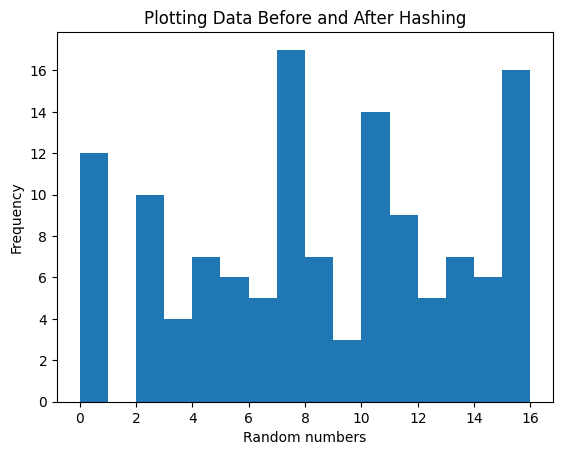

Entropy:  0.9966619137320386
Chi-squared (4.624, 0.03152763431172012)
After processing: 


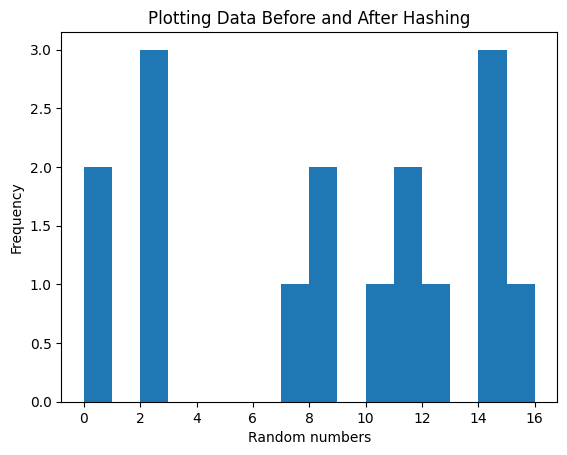

Entropy:  0.9823166080205501
Chi-squared (1.5625, 0.21129954733371048)
Ediff, Cdiff -0.01434530571148851 (-3.0614999999999997, 0.17977191302199036)
(0.042221175247162394, 'The sequence is considered random.')
--------------------------------------------------
Reading data from datasets/sherbrooke_iteration_100_30_1000bits.txt
(0.7716705035436164, 'The sequence is considered random.')


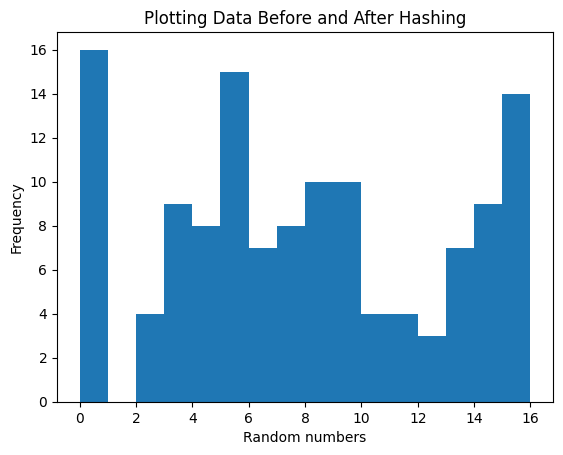

Entropy:  0.9972253609153698
Chi-squared (3.844, 0.04992428403969773)
After processing: 


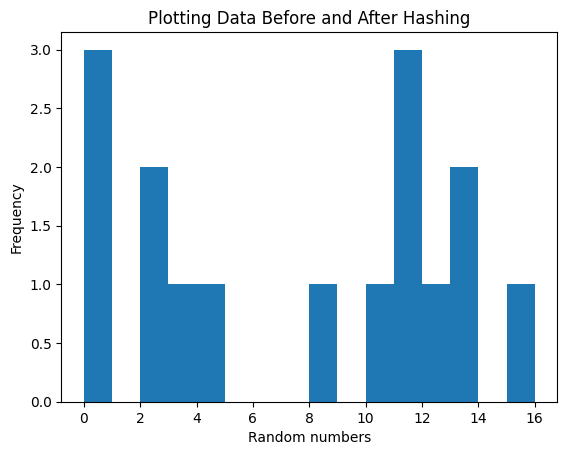

Entropy:  0.9744894033980523
Chi-squared (2.25, 0.13361440253771584)
Ediff, Cdiff -0.022735957517317495 (-1.5939999999999999, 0.0836901184980181)
(0.7716705035436164, 'The sequence is considered random.')
--------------------------------------------------
Reading data from datasets/quantum_mod2_sherbrooke.txt
(1.0, 'The sequence is considered random.')


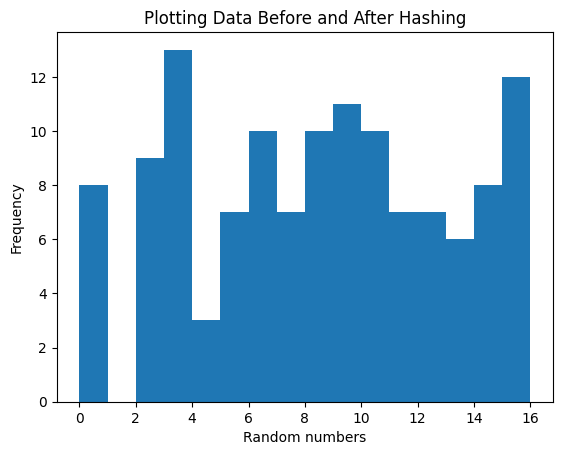

Entropy:  0.9995123141215677
Chi-squared (0.676, 0.4109675220883362)
After processing: 


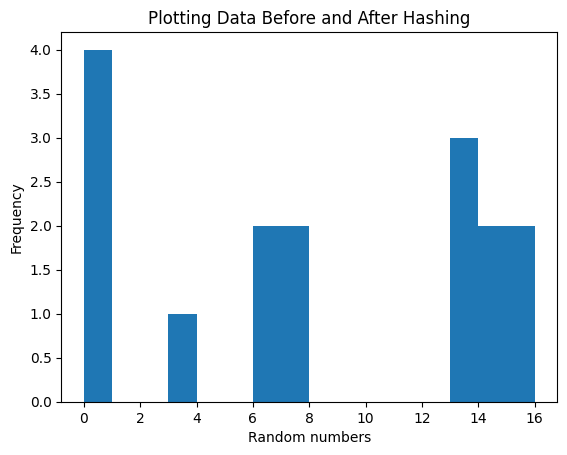

Entropy:  0.9899927915575186
Chi-squared (0.9411764705882353, 0.33197546708273684)
Ediff, Cdiff -0.009519522564049088 (0.26517647058823524, -0.07899205500559936)
(1.0, 'The sequence is considered random.')
--------------------------------------------------


In [15]:
N = 4
for file in list_files_in_directory("datasets"):
    print(f"Reading data from {file}")
    full_bitstring = read_full_file_as_str(file)
    dataset = np.array(bitstring_to_int_array(full_bitstring, N))
    print(spectral_fft_test(full_bitstring))
    #toefflize_with_extra(full_bitstring, dataset, N)
    ediff, chidiff = entropize(full_bitstring, dataset, N, True, True)
    print("Ediff, Cdiff", ediff, chidiff)
    print(spectral_fft_test(full_bitstring))
    print('-'*50)
